## 5. Image Binary Classification (30 pts)



For Question 5 of the Python project, please complete it using two distinct Jupyter Notebook scripts. This entails using one notebook for the original dataset and another for the modified dataset. Consequently, you will be submitting a total of three .ipynb files as part of your Python project, ensuring clear separation and organization of your work.

Your tasks:
1. Your first task is to re-implement the classification model that was covered in our class. Please start from scratch and write the code independently. You can refer to the original code provided on Brightspace if you encounter any difficulties, but try to write the code on your own to reinforce your understanding.

2. After implementing the classification model, **report the indices of all the images in the test set for which the model's predictions are incorrect.** To maintain consistency with Python’s convention, please begin your indexing with 0. Additionally, **display the images of 4 of these failed cases for visual examination (you can display more if you like)**. This analysis might help us identify instances where the model is struggling in some applications.

3. Now you will modify the code to treat the dataset differently. The first 160 images plus the last digit of your Student ID will constitute the new training set, while the remaining images in the original training set will be your new test set. There are 209 images in the original training set. For example, if your ID ends with 0, the first 160 images will form your training set, and the remaining 49 images will be part of your test set. The test dataset is discarded and no longer used. Re-train the model using this modified dataset and **report the training and test accuracies**. Additionally, **provide the indices of all the images in the test set for which the model's predictions are incorrect. Display 4 of these misclassified images for further examination.**

By completing these tasks, you'll gain valuable insights into the classification model's performance and its behavior under different training and testing conditions.


  Datasets: [train]: train_catvnoncat.h5, [test]: test_catvnoncat.h5

In [43]:
# Q5
# Importing libraries
#In this part, the original cat vs. non-cat dataset from the H5 files is used to train a pretrained ResNet-18 model.
 # - train_catvnoncat.h5 → initial training set
 # - test_catvnoncat.h5 → initial testing set

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [44]:
#The raw 64x64x3 numpy pictures are transformed by these methods into 224x224 normalized tensors that are appropriate for ResNet.
 # Resize → to the input size that ResNet-18 # expects.    
 # Small augmentation using RandomHorizontalFlip
 # To match pretrained statistics, normalize ImageNet's mean and standard deviation.
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet means
        std=[0.229, 0.224, 0.225]     # ImageNet stds
    ),
])


In [45]:
# Transforms unprocessed numpy pictures and labels into a format that PyTorch can comprehend.
 # Returns: # picture → converted tensor
 # label → integer (0 = cat, 1 = non-cat)
 # index → initial index for reporting misclassifications
class NumpyImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.reshape(-1).astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index]        # numpy HWC, uint8
        label = self.labels[index]        # scalar 0 or 1

        if self.transform is not None:
            image = self.transform(image)

        return image, label, index


In [46]:
# The training and testing files are loaded in their original format.
 #  In Q5, we only honor the # professor's initial separation; no custom splitting is carried out.
def load_cat_dataset(train_path, test_path=None):
    import h5py
    import numpy as np

    # Load training set
    with h5py.File(train_path, "r") as f:
        train_images = np.array(f["train_set_x"][:])   # shape: (m_train, 64, 64, 3)
        train_labels = np.array(f["train_set_y"][:])   # shape: (m_train,)

    class_names = ["non-cat", "cat"]   # Provided in the original dataset

    # Load test set if provided
    if test_path is not None:
        with h5py.File(test_path, "r") as f:
            test_images = np.array(f["test_set_x"][:])
            test_labels = np.array(f["test_set_y"][:])

        return train_images, train_labels, test_images, test_labels, class_names

    # If no test set is given (for modified dataset notebook)
    return train_images, train_labels, None, None, class_names


In [47]:
#train_one_epoch
 # - forward pass 
 # - compute loss 
 # - backpropagation 
 # - parameter update # - evaluate_model:
 # - Gathers predictions and indices for misclassification analysis # - NO training (model.eval + no_grad)
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels, indices in data_loader:
        images = images.to(device)
        labels_tensor = labels.float().unsqueeze(1).to(device)  # (B,1)

        optimizer.zero_grad()
        outputs = model(images)          # (B,1) logits
        loss = criterion(outputs, labels_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).int().cpu().squeeze(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_indices = []

    with torch.no_grad():
        for images, labels, indices in data_loader:
            images = images.to(device)
            labels_tensor = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels_tensor)

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int().cpu().squeeze(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.numpy())
            all_labels.append(labels.numpy())
            all_indices.append(indices.numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_indices = np.concatenate(all_indices)

    return epoch_loss, epoch_acc, all_preds, all_labels, all_indices


In [48]:
# Shows up to 4 incorrectly predicted images from the test set.
# Each image displays:
#      - true label
#      - predicted label
#      - original index in dataset (helps debugging)
def show_misclassified(images_raw, mis_indices, true_labels, pred_labels, num_to_show=4):
    num_to_show = min(num_to_show, len(mis_indices))
    if num_to_show == 0:
        print("No misclassified images.")
        return

    plt.figure(figsize=(12, 3))
    for i in range(num_to_show):
        idx = mis_indices[i]
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(images_raw[idx].astype(np.uint8))
        plt.axis("off")
        plt.title(f"idx {idx}\ntrue={true_labels[idx]}, pred={pred_labels[idx]}")
    plt.tight_layout()
    plt.show()


In [49]:
# -------- Load ORIGINAL train + test datasets --------
train_images, train_labels, test_images, test_labels, class_names = load_cat_dataset(
    "train_catvnoncat.h5",
    "test_catvnoncat.h5"
)

print("Train images:", train_images.shape)
print("Test images :", test_images.shape)


Train images: (209, 64, 64, 3)
Test images : (50, 64, 64, 3)


In [50]:
# -------- Build Dataset and DataLoaders --------
train_dataset = NumpyImageDataset(train_images, train_labels, transform=transform)
test_dataset = NumpyImageDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [51]:
#The original model predicts 1000 ImageNet classes, thus only the last fully-connected layer is altered.
 # In this case, binary classification just requires one logit.
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)

model = model.to(device)


/Users/rishabhgosain/Documents/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rishabhgosain/Documents/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
# -------- Train model on ORIGINAL training set --------
num_epochs = 5  # you can increase if training is fast enough

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    scheduler.step()
    print(f"Epoch {epoch+1:02d}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


Epoch 01/5 - Train Loss: 1.0342, Train Acc: 0.3445
Epoch 02/5 - Train Loss: 0.8011, Train Acc: 0.3923
Epoch 03/5 - Train Loss: 0.6216, Train Acc: 0.5455
Epoch 04/5 - Train Loss: 0.4989, Train Acc: 0.7225
Epoch 05/5 - Train Loss: 0.3837, Train Acc: 0.8325


In [53]:
# -------- Evaluate on ORIGINAL train and test sets --------
train_loss, train_acc, train_preds, train_true, train_idx = evaluate_model(
    model, train_loader, criterion, device
)
test_loss, test_acc, test_preds, test_true, test_idx = evaluate_model(
    model, test_loader, criterion, device
)

print("\nFinal Training Accuracy (original split):", train_acc)
print("Final Test Accuracy (original split):     ", test_acc)

print("\nClassification report on TEST set:")
print(classification_report(test_true, test_preds, digits=4))



Final Training Accuracy (original split): 0.9282296650717703
Final Test Accuracy (original split):      0.92

Classification report on TEST set:
              precision    recall  f1-score   support

           0     1.0000    0.7647    0.8667        17
           1     0.8919    1.0000    0.9429        33

    accuracy                         0.9200        50
   macro avg     0.9459    0.8824    0.9048        50
weighted avg     0.9286    0.9200    0.9170        50



Indices of misclassified test images (starting from 0):
[13, 29, 39, 45]


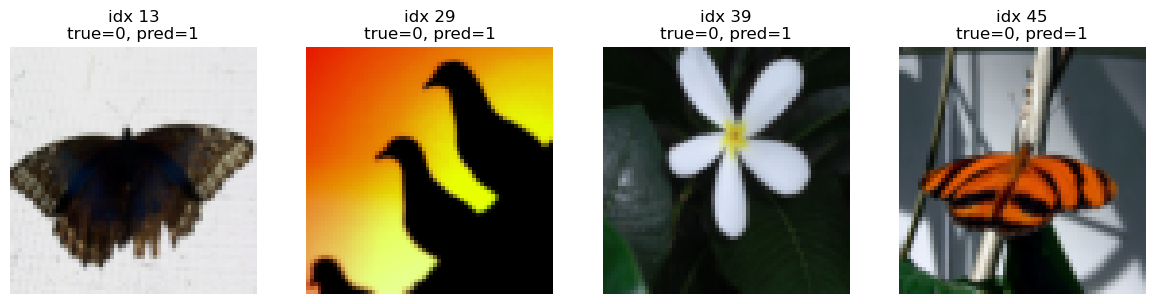

In [54]:
# -------- Misclassified indices + 4 images (ORIGINAL test set) --------
mis_mask = test_preds != test_true
mis_indices = test_idx[mis_mask]

print("Indices of misclassified test images (starting from 0):")
print(mis_indices.tolist())

show_misclassified(
    images_raw=test_images,
    mis_indices=mis_indices,
    true_labels=test_true,
    pred_labels=test_preds,
    num_to_show=4
)
